In [318]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px


In [319]:
# Ignore certain warnings
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [320]:
df_nyc = pd.read_csv('nyc_cleaned.csv', low_memory=False)

In [321]:
# Get statistics on cleaned dataframe
print(len(df_nyc))
print(df_nyc['Property ID'].nunique())

200225
38350


In [322]:
# Building count details
df_sqft = df_nyc.sort_values('year').drop_duplicates('Property ID', keep='last')[['Primary Property Type - Self Selected','sqft']]

building_counts = df_sqft.groupby('Primary Property Type - Self Selected')['sqft'].count()

building_counts.sort_values(ascending=False)

Primary Property Type - Self Selected
Multifamily Housing                                      24723
Office                                                    3161
K-12 School                                               2133
Hotel                                                      849
Non-Refrigerated Warehouse                                 622
                                                         ...  
Supermarché/épicerie                                         1
Indoor Arena                                                 1
Convention Center                                            1
Convenience Store without Gas Station                        1
Personal Services (Health/Beauty, Dry Cleaning, etc.)        1
Name: sqft, Length: 79, dtype: int64

In [323]:
# Make a treegraph

# Sort and get the top 6
top_6 = building_counts.sort_values(ascending=False).head(6)

# Sum the rest and create a new Series for 'Other'
other_sum = building_counts[~building_counts.index.isin(top_6.index)].sum()
other_series = pd.Series({'Other': other_sum})

# Concatenate the two
building_counts_final = pd.concat([top_6, other_series])

# Convert Series to DataFrame with proper column names
df_treemap = building_counts_final.reset_index()
df_treemap.columns = ['Property Type', 'Count']

# Add line breaks for long text
df_treemap['Property Type'].iloc[4] = 'Non-Refrigerated<br>Warehouse'
df_treemap['Property Type'].iloc[5] = 'College/<br>University'

# Create the treemap using the wrapped labels
fig = px.treemap(
    df_treemap,
    path=['Property Type'],
    values='Count',
    title="Building Count by Property Type (Top 6 + Other)",
    width=1000,
    height=600
)

fig.update_traces(textinfo="label+value")

fig.show()

C:\Users\etien\AppData\Local\Temp\ipykernel_2340\161749724.py:18: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\etien\AppData\Local\Temp\ipykernel_2340\161749724.py:19: FutureWarning:

ChainedAssignmentError: behaviour will change i

In [324]:
for i in range(0,6):
    print(building_counts_final.iloc[i] / building_counts_final.sum())

0.6446675358539765
0.08242503259452412
0.05561929595827901
0.02213820078226858
0.01621903520208605
0.013350717079530639


In [325]:
# Array of building types with 500+ unique buildings 
most_common_buildings = ['Multifamily Housing','Office','K-12 School','Hotel','Non-Refrigerated Warehouse','College/University']

In [326]:
# Narrow down features

current_features = [
    'Property ID',
    'year',
    'age',
    'Primary Property Type - Self Selected',
    'ln_source_eui',
    'Weather Normalized Source EUI (kBtu/ft²)',
    'Weather Normalized Source Energy Use (kBtu)',
    'sqft',
    'numfloors',
    'Electricity Use (kBtu)',
    'Natural Gas Use (kBtu)',
    'District Steam Use (kBtu)',
    'Electricity Use (kBtu)_ratio',
    'Natural Gas Use (kBtu)_ratio',
    'District Steam Use (kBtu)_ratio',
    'electricity_primary',
    'natural_primary',
    'steam_primary',
    'assesstot',
    'assesstot_persqft',
    'yearalter',
    'age_bin',
    'Office - Worker Density (Number per 1,000 sq ft)',
    'Multifamily Housing - Number of Bedrooms',
    'age_bin',
    'sqft_bin'
]

df_nyc_simp = df_nyc[current_features]


In [327]:
# Make post_covid boolean
df_nyc_simp['post_covid'] = df_nyc_simp['year'].apply(lambda x: 0 if x < 2020 else 1)

In [328]:
# Get only the most common building types

df_nyc_graph = df_nyc_simp[df_nyc_simp['Primary Property Type - Self Selected'].isin(most_common_buildings)]

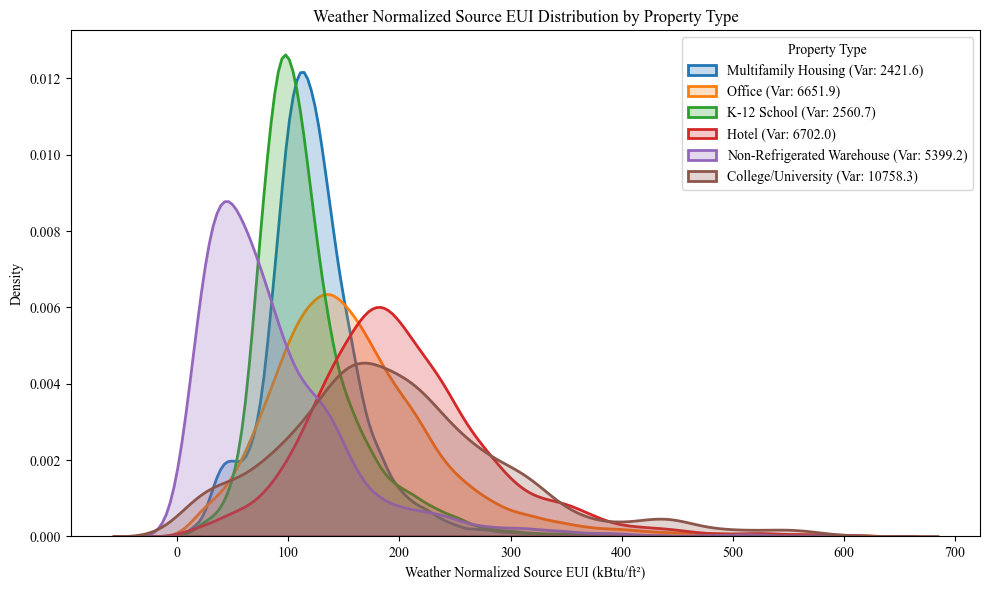

In [329]:
plt.figure(figsize=(10, 6))

for category in most_common_buildings:
    subset = df_nyc_graph[df_nyc_graph['Primary Property Type - Self Selected'] == category]
    variance = subset['Weather Normalized Source EUI (kBtu/ft²)'].var()
    
    # Plot KDE
    kde = sns.kdeplot(
        subset['Weather Normalized Source EUI (kBtu/ft²)'],
        label=f"{category} (Var: {variance:.1f})",
        linewidth=2,
        fill=True
    )

plt.xlabel("Weather Normalized Source EUI (kBtu/ft²)")
plt.ylabel("Density")
plt.title("Weather Normalized Source EUI Distribution by Property Type")
plt.legend(title="Property Type")
plt.tight_layout()

plt.savefig('office_housing_density.png')
plt.show()


In [330]:
df_nyc_gb

,Primary Property Type - Self Selected,year,Weather Normalized Source EUI (kBtu/ft²)
0,College/University,2014,196.462791
1,College/University,2015,249.933065
2,College/University,2016,239.754362
3,College/University,2017,194.882031
4,College/University,2018,187.143046
5,College/University,2019,202.372340
6,College/University,2020,172.134158
7,College/University,2021,170.840789
8,College/University,2022,170.137447
9,College/University,2023,157.142857


In [331]:
136.727492/127.013918

1.0764764535489726

In [332]:
df_avg

,year,Weather Normalized Source EUI (kBtu/ft²)
0,2014,146.757442
1,2015,151.710532
2,2016,150.868274
3,2017,144.332543
4,2018,139.693057
5,2019,136.459453
6,2020,129.490264
7,2021,130.096449
8,2022,128.073025
9,2023,127.013918


In [333]:
import plotly.graph_objects as go

# Group by property type and year
df_nyc_gb = df_nyc_graph.groupby(['Primary Property Type - Self Selected', 'year'])['Weather Normalized Source EUI (kBtu/ft²)'].mean().reset_index()

# Compute yearly average across all property types
df_avg = df_nyc_simp.groupby('year')['Weather Normalized Source EUI (kBtu/ft²)'].mean().reset_index()

# Plot main figure
fig = px.line(
    df_nyc_gb,
    x="year",
    y="Weather Normalized Source EUI (kBtu/ft²)",
    color="Primary Property Type - Self Selected",
    labels={"Weather Normalized Source EUI (kBtu/ft²)": "Wn Source EUI (kBtu/ft²)"},
    width=1000,
    height=400
)

# Add average line trace
fig.add_trace(
    go.Scatter(
        x=df_avg["year"],
        y=df_avg["Weather Normalized Source EUI (kBtu/ft²)"],
        mode="lines",
        name="Average For All Property Types",
        line=dict(color="black", width=3, dash="dash")
    )
)

# Layout styling
fig.update_layout(
    font=dict(family="Times New Roman", size=14),
    title_font=dict(size=22, family="Times New Roman"),
    legend_title=dict(font=dict(family="Times New Roman", size=14)),
    legend=dict(font=dict(size=16)),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    xaxis=dict(tickfont=dict(size=14)),
    yaxis=dict(tickfont=dict(size=14)),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()


In [334]:
# Sort by year to ensure correct ordering
df_sorted = df_nyc_gb.sort_values(['Primary Property Type - Self Selected', 'year'])

# Get the first and last values per property type
first_values = df_sorted.groupby('Primary Property Type - Self Selected').first()['Weather Normalized Source EUI (kBtu/ft²)']
last_values = df_sorted.groupby('Primary Property Type - Self Selected').last()['Weather Normalized Source EUI (kBtu/ft²)']

# Compute percent change
percent_change = ((last_values - first_values) / first_values) * 100

# Round for readability
percent_change = percent_change.round(2) * -1

C:\Users\etien\AppData\Local\Temp\ipykernel_2340\2637864866.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




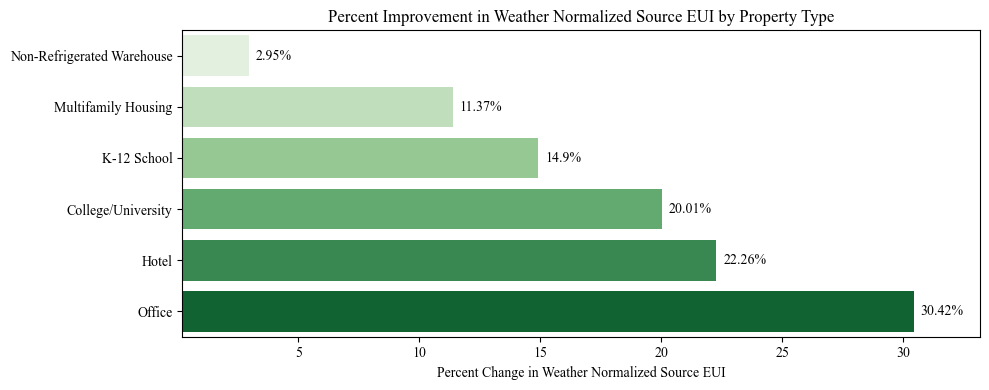

In [335]:
# Convert Series to DataFrame and reset index
df_percent_change = percent_change.sort_values().reset_index()
df_percent_change.columns = ['Property Type', 'Percent Change']

# Calculate padding for x-axis limits
min_val = df_percent_change['Percent Change'].min()
max_val = df_percent_change['Percent Change'].max()
padding = (max_val - min_val) * 0.1  # 10% padding on each side

# Plot
plt.figure(figsize=(10, 4))
ax = sns.barplot(
    data=df_percent_change,
    y='Property Type',
    x='Percent Change',
    palette='Greens'
)

# Annotate bars with values
for i, row in df_percent_change.iterrows():
    offset = 0.3 if row['Percent Change'] >= 0 else -1
    ha_align = 'left' if row['Percent Change'] >= 0 else 'right'
    ax.text(row['Percent Change'] + offset, i, f"{row['Percent Change']}%", 
            va='center', ha=ha_align, fontsize=10)

# Set x-axis limits to avoid cutting off labels
plt.xlim(min_val - padding, max_val + padding)

# Styling
plt.xlabel("Percent Change in Weather Normalized Source EUI")
plt.ylabel("")
plt.title("Percent Improvement in Weather Normalized Source EUI by Property Type")
plt.tight_layout()

plt.savefig('eui_improvements_horizontal.png')
plt.show()

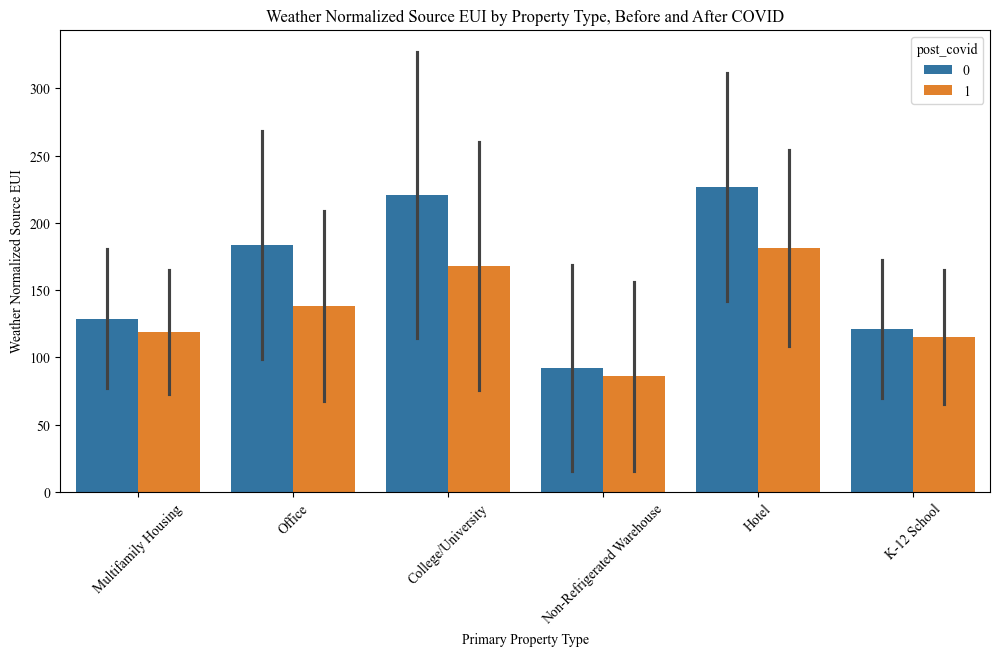

In [336]:
# Plot
plt.figure(figsize=(12, 6))

mpl.rcParams['font.family'] = 'Times New Roman'

sns.barplot(
    data=df_nyc_graph, 
    x='Primary Property Type - Self Selected', 
    y='Weather Normalized Source EUI (kBtu/ft²)', 
    hue='post_covid', 
    errorbar='sd',
)

plt.xticks(rotation=45)
plt.xlabel('Primary Property Type')
plt.ylabel('Weather Normalized Source EUI')
plt.title('Weather Normalized Source EUI by Property Type, Before and After COVID')

plt.savefig('source_eui_barplot.png')

plt.show()

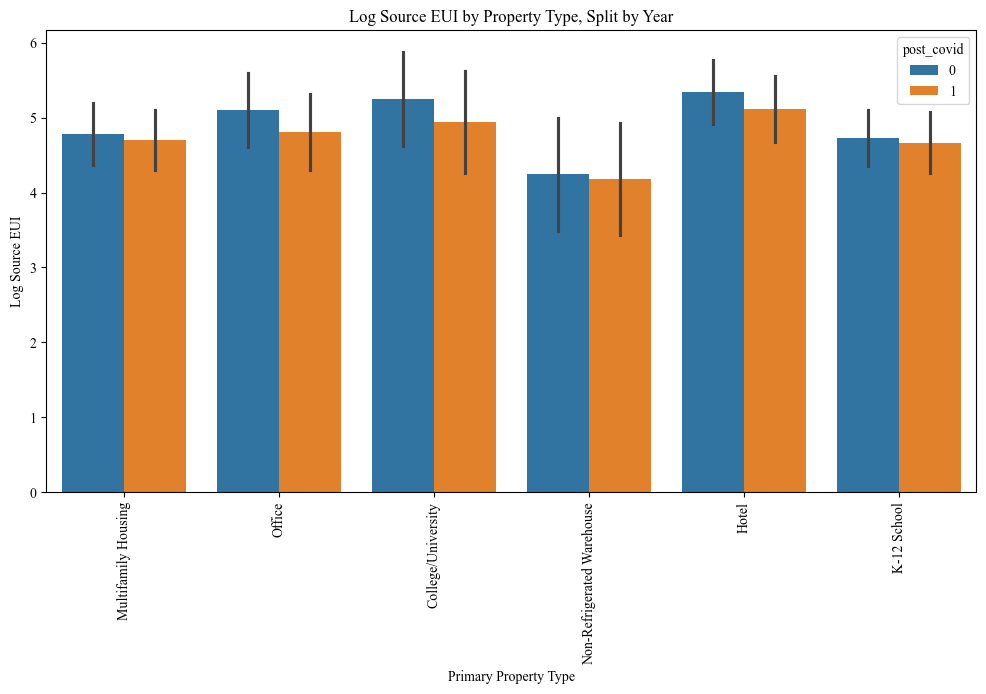

In [337]:
# Plot
plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_nyc_graph, 
    x='Primary Property Type - Self Selected', 
    y='ln_source_eui', 
    hue='post_covid', 
    errorbar='sd'
)

plt.xticks(rotation=90)
plt.xlabel('Primary Property Type')
plt.ylabel('Log Source EUI')
plt.title('Log Source EUI by Property Type, Split by Year')
plt.show()

# Run Regression

In [339]:
# check_features = [
#     'age_bin',
#     'Primary Property Type - Self Selected',
#     'sqft_bin',
#     'numfloors',
#     'electricity_primary',
#     'natural_primary',
#     'steam_primary',
#     'ln_source_eui',
#     'year',
#     'assesstot',
#     'assesstot_persqft',
#     'Weather Normalized Source EUI (kBtu/ft²)'
# ]

check_features = [
    'age',
    'Primary Property Type - Self Selected',
    'sqft',
    'numfloors',
    'Electricity Use (kBtu)_ratio',
    'Natural Gas Use (kBtu)_ratio',
    'District Steam Use (kBtu)_ratio',
    'ln_source_eui',
    'year',
    'assesstot_persqft',
    'assesstot',
    'Weather Normalized Source EUI (kBtu/ft²)'
]
    
df_features = df_nyc_graph[check_features]

In [340]:
# Get encoded
df_features = pd.get_dummies(df_features, columns=['Primary Property Type - Self Selected'])
df_features = df_features.drop(columns=['Primary Property Type - Self Selected_Office'])
df_features = df_features.astype({col: 'float64' for col in df_features.select_dtypes('bool').columns})

df_features = df_features.replace([np.inf, -np.inf], np.nan)  # convert infs to NaN

df_features_main = df_features.drop('year',axis=1)

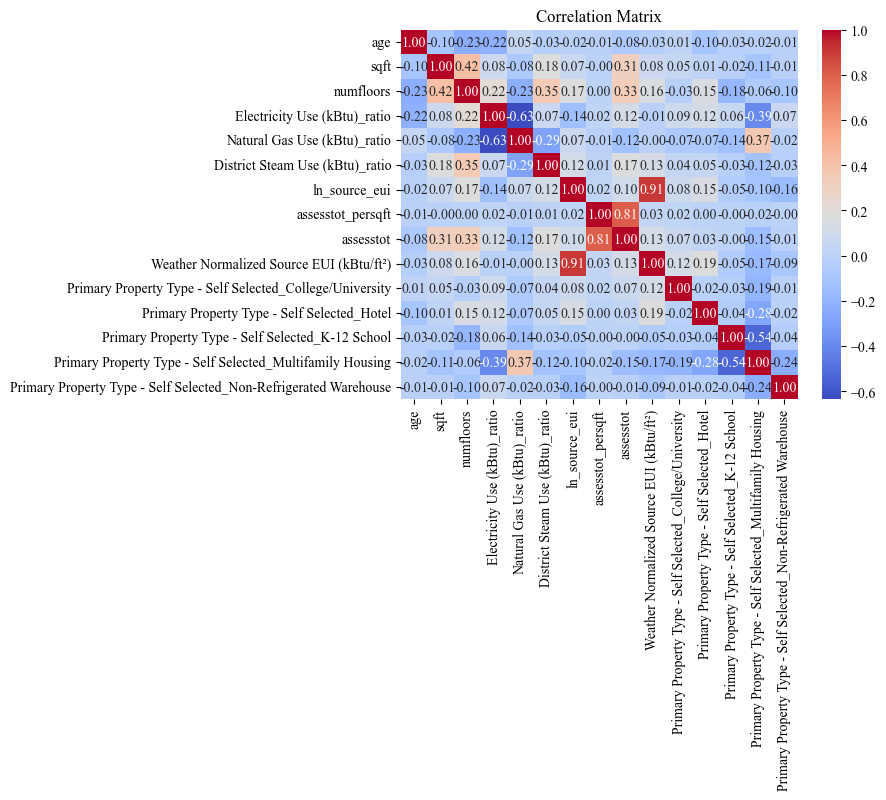

In [341]:
# Compute correlations
correlations = df_features_main.corr()['ln_source_eui'].sort_values(ascending=False).dropna()

# Visualize
sns.heatmap(df_features_main.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Try using raw values of Electricity / Natural Gas instead of ratios

In [342]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Define features and target
X = df_features_main.drop(columns=['ln_source_eui', 'Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_main['ln_source_eui']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest with stan
rf_wnseui = RandomForestRegressor(n_estimators=100, random_state=42)
rf_wnseui.fit(X_train, y_train)

# Predict
y_pred_wnseui = rf_wnseui.predict(X_test)

# Evaluate
r2_wnseui = r2_score(y_test, y_pred_wnseui)
print(f"Random Forest R² Score: {r2_wnseui:.4f}")

Random Forest R² Score: 0.6951


In [343]:
# Run the same model but for its natural logarithm

# Define features and target
X = df_features_main.drop(columns=['ln_source_eui', 'Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_main['Weather Normalized Source EUI (kBtu/ft²)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf_nl = RandomForestRegressor(n_estimators=100, random_state=42)
rf_nl.fit(X_train, y_train)

# Predict
y_pred_nl = rf_nl.predict(X_test)

# Evaluate
r2_nl = r2_score(y_test, y_pred_nl)
print(f"Random Forest R² Score: {r2_nl:.4f}")

Random Forest R² Score: 0.6869


In [344]:
# Now split data into pre and post COVID sets
df_features_pre = df_features[df_features['year'] < 2020].drop('year',axis=1)
df_features_post = df_features[df_features['year'] >= 2020].drop('year',axis=1)

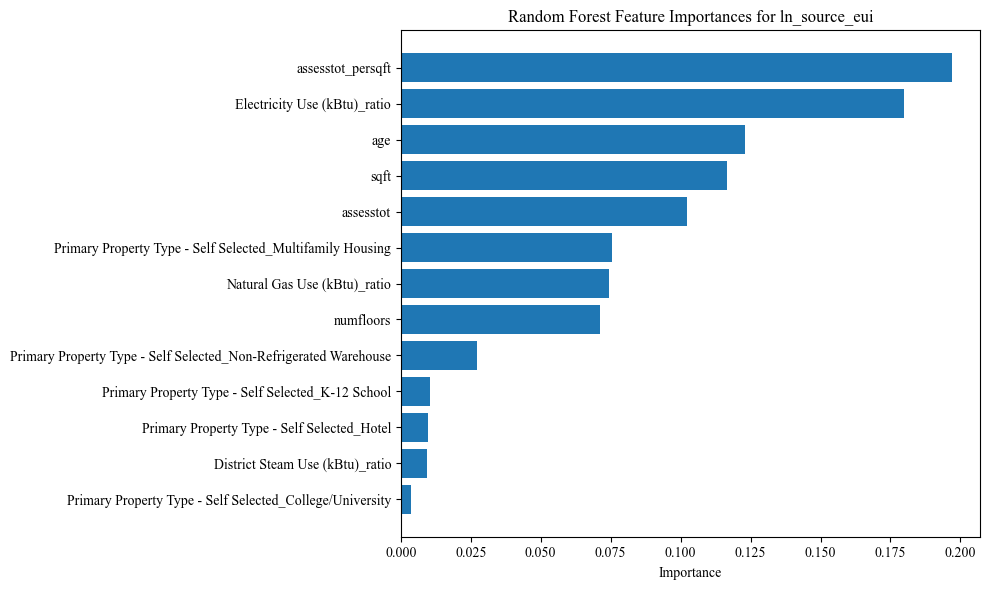

In [346]:
# Feature Importances
importances = rf_wnseui.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances for ln_source_eui')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

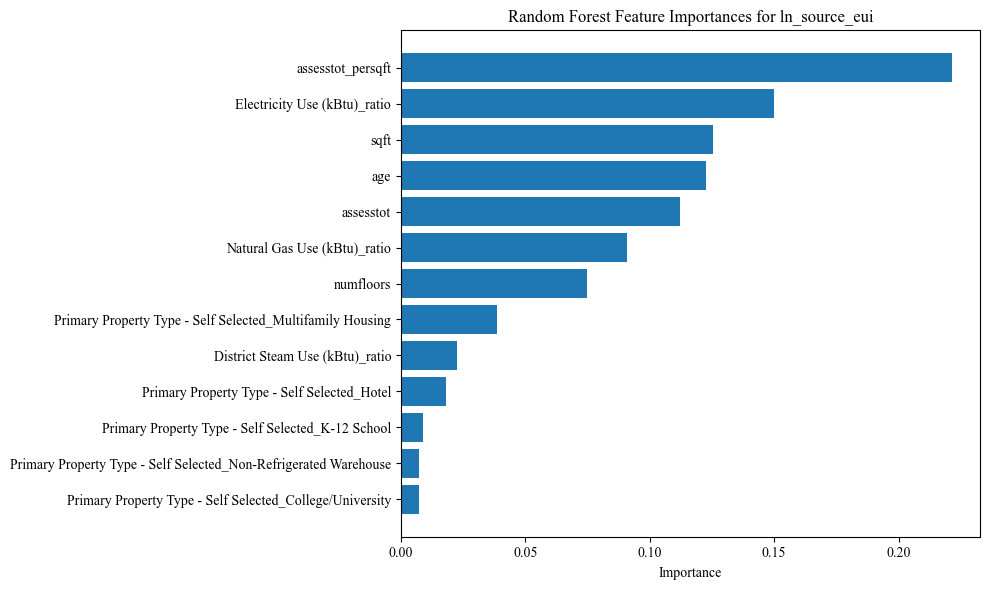

In [348]:
# Feature Importances
importances = rf_nl.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances for ln_source_eui')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Conduct ITS for COVID

In [350]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Aggregate to yearly average EUI across all buildings
df_its = df_nyc.groupby('year')['Weather Normalized Source EUI (kBtu/ft²)'].mean().reset_index()

# Create time and post-COVID variables
df_its['time'] = range(1, len(df_its) + 1)
df_its['post_covid'] = (df_its['year'] >= 2020).astype(int)
df_its['time_post_covid'] = df_its['time'] * df_its['post_covid']

# Define outcome and predictors
y = df_its['Weather Normalized Source EUI (kBtu/ft²)']
X = df_its[['time', 'post_covid', 'time_post_covid']]
X = sm.add_constant(X)  # adds intercept

# Fit the ITS model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.929
Model:                                                  OLS   Adj. R-squared:                  0.893
Method:                                       Least Squares   F-statistic:                     26.06
Date:                                      Thu, 01 May 2025   Prob (F-statistic):           0.000771
Time:                                              16:54:22   Log-Likelihood:                -23.064
No. Observations:                                        10   AIC:                             54.13
Df Residuals:                                             6   BIC:                             55.34
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust                                

C:\Users\etien\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



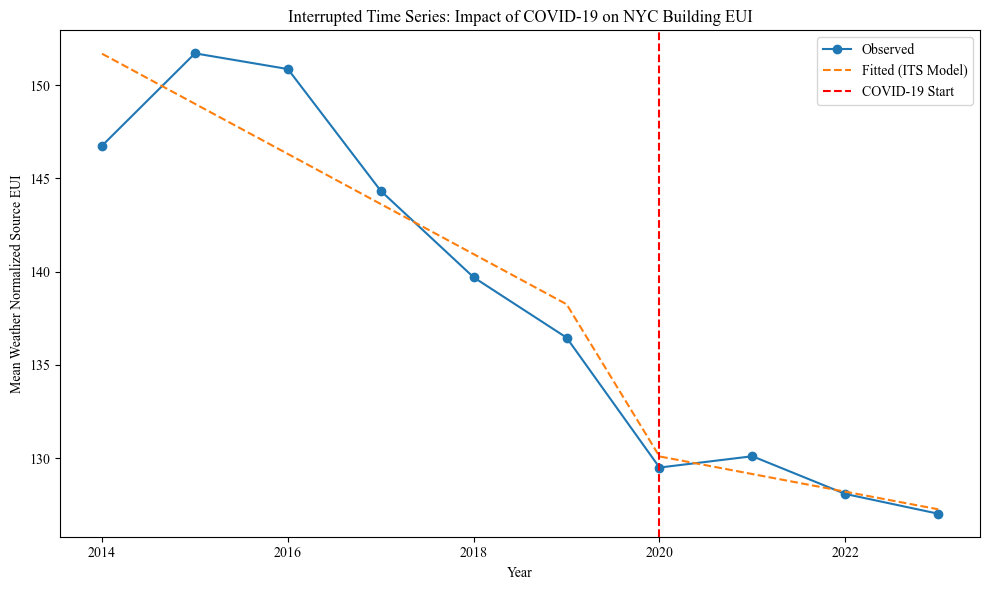

In [352]:
# Predict values from model
df_its['fitted'] = model.predict(X)

# Plot observed vs fitted
plt.figure(figsize=(10, 6))
plt.plot(df_its['year'], df_its['Weather Normalized Source EUI (kBtu/ft²)'], label='Observed', marker='o')
plt.plot(df_its['year'], df_its['fitted'], label='Fitted (ITS Model)', linestyle='--')
plt.axvline(2020, color='red', linestyle='dashed', label='COVID-19 Start')
plt.xlabel("Year")
plt.ylabel("Mean Weather Normalized Source EUI")
plt.title("Interrupted Time Series: Impact of COVID-19 on NYC Building EUI")
plt.legend()
plt.tight_layout()
plt.show()



=== ITS for Multifamily Housing ===


C:\Users\etien\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.961
Model:                                                  OLS   Adj. R-squared:                  0.941
Method:                                       Least Squares   F-statistic:                     48.76
Date:                                      Thu, 01 May 2025   Prob (F-statistic):           0.000132
Time:                                              16:54:28   Log-Likelihood:                -15.639
No. Observations:                                        10   AIC:                             39.28
Df Residuals:                                             6   BIC:                             40.49
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust                                

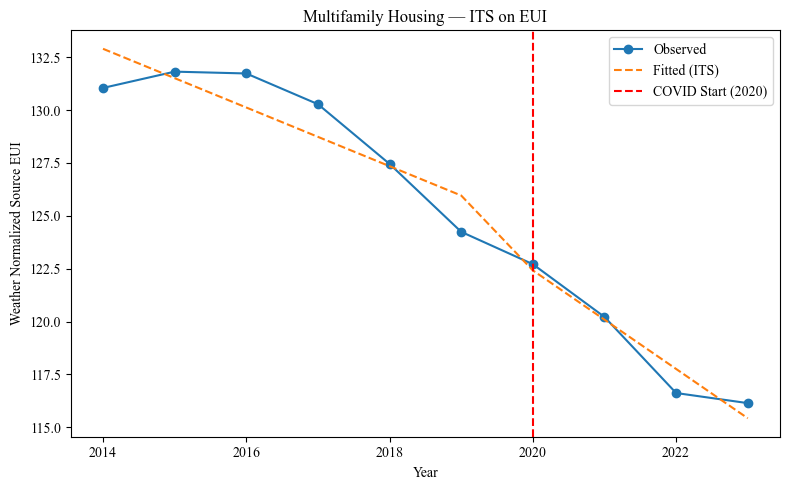


=== ITS for Office ===


C:\Users\etien\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.984
Model:                                                  OLS   Adj. R-squared:                  0.976
Method:                                       Least Squares   F-statistic:                     121.3
Date:                                      Thu, 01 May 2025   Prob (F-statistic):           9.27e-06
Time:                                              16:54:29   Log-Likelihood:                -25.693
No. Observations:                                        10   AIC:                             59.39
Df Residuals:                                             6   BIC:                             60.60
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust                                

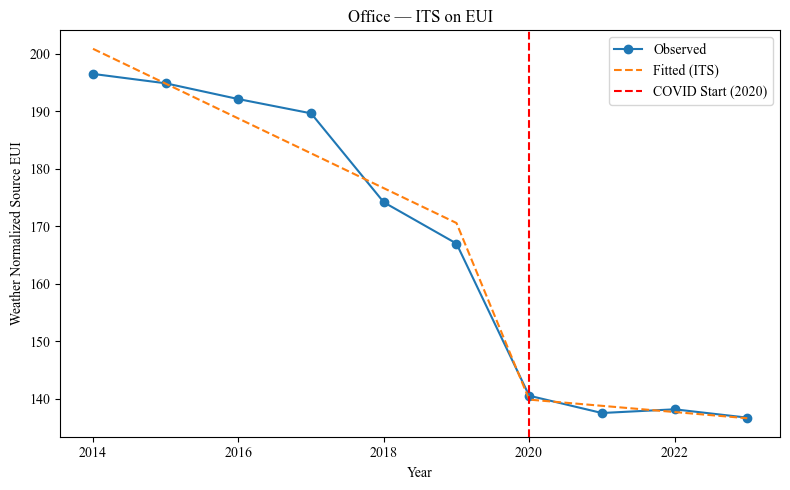


=== ITS for K-12 School ===
                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.809
Model:                                                  OLS   Adj. R-squared:                  0.714
Method:                                       Least Squares   F-statistic:                     8.490
Date:                                      Thu, 01 May 2025   Prob (F-statistic):             0.0140
Time:                                              16:54:29   Log-Likelihood:                -26.647
No. Observations:                                        10   AIC:                             61.29
Df Residuals:                                             6   BIC:                             62.51
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust   

C:\Users\etien\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



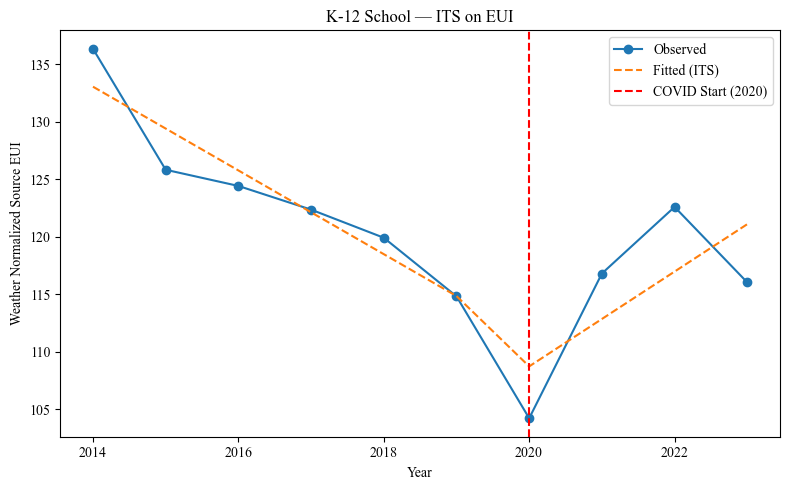


=== ITS for Hotel ===
                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.989
Model:                                                  OLS   Adj. R-squared:                  0.984
Method:                                       Least Squares   F-statistic:                     186.9
Date:                                      Thu, 01 May 2025   Prob (F-statistic):           2.59e-06
Time:                                              16:54:30   Log-Likelihood:                -23.803
No. Observations:                                        10   AIC:                             55.61
Df Residuals:                                             6   BIC:                             56.82
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust         

C:\Users\etien\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



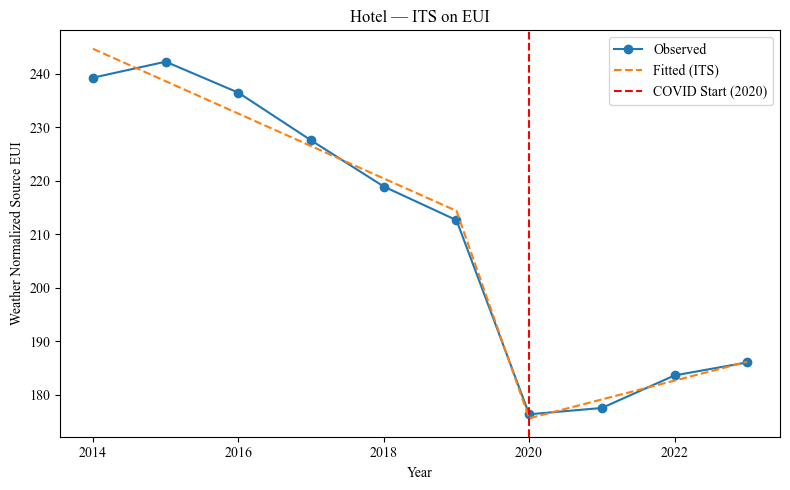


=== ITS for Non-Refrigerated Warehouse ===
                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.565
Model:                                                  OLS   Adj. R-squared:                  0.347
Method:                                       Least Squares   F-statistic:                     2.595
Date:                                      Thu, 01 May 2025   Prob (F-statistic):              0.148
Time:                                              16:54:31   Log-Likelihood:                -24.649
No. Observations:                                        10   AIC:                             57.30
Df Residuals:                                             6   BIC:                             58.51
Df Model:                                                 3                                         
Covariance Type:                               

C:\Users\etien\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



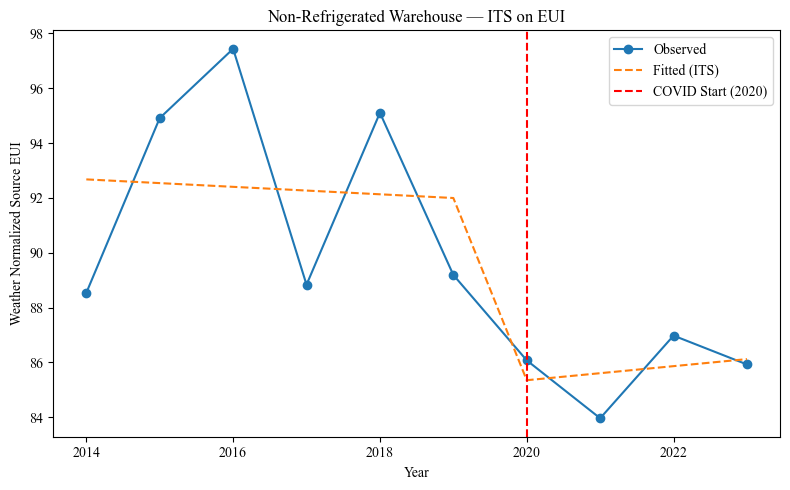


=== ITS for College/University ===
                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.650
Model:                                                  OLS   Adj. R-squared:                  0.474
Method:                                       Least Squares   F-statistic:                     3.709
Date:                                      Thu, 01 May 2025   Prob (F-statistic):             0.0807
Time:                                              16:54:32   Log-Likelihood:                -42.545
No. Observations:                                        10   AIC:                             93.09
Df Residuals:                                             6   BIC:                             94.30
Df Model:                                                 3                                         
Covariance Type:                                  nonro

C:\Users\etien\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



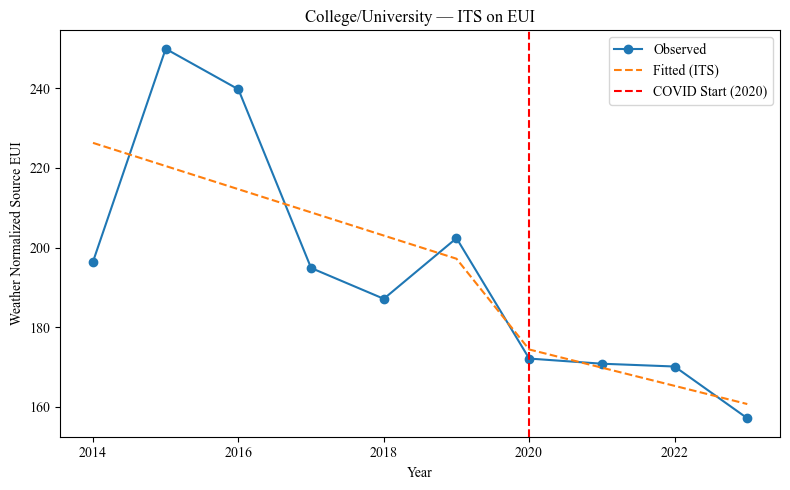

In [354]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

most_common_buildings = ['Multifamily Housing', 'Office', 'K-12 School', 'Hotel', 
                         'Non-Refrigerated Warehouse', 'College/University']

# Loop through each property type
for building_type in most_common_buildings:
    print(f"\n=== ITS for {building_type} ===")

    # Subset to that building type
    df_sub = df_nyc[df_nyc['Primary Property Type - Self Selected'] == building_type]

    # Aggregate to yearly average EUI
    df_its = df_sub.groupby('year')['Weather Normalized Source EUI (kBtu/ft²)'].mean().reset_index()

    # Skip if insufficient data
    if df_its.shape[0] < 6:
        print("Not enough data for robust ITS analysis.\n")
        continue

    # Add ITS variables
    df_its['time'] = range(1, len(df_its) + 1)
    df_its['post_covid'] = (df_its['year'] >= 2020).astype(int)
    df_its['time_post_covid'] = df_its['time'] * df_its['post_covid']

    # Define variables
    y = df_its['Weather Normalized Source EUI (kBtu/ft²)']
    X = df_its[['time', 'post_covid', 'time_post_covid']]
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()

    # Print summary
    print(model.summary())

    # Plot
    df_its['fitted'] = model.predict(X)

    plt.figure(figsize=(8, 5))
    plt.plot(df_its['year'], df_its['Weather Normalized Source EUI (kBtu/ft²)'], label='Observed', marker='o')
    plt.plot(df_its['year'], df_its['fitted'], label='Fitted (ITS)', linestyle='--')
    plt.axvline(2020, color='red', linestyle='dashed', label='COVID Start (2020)')
    plt.title(f"{building_type} — ITS on EUI")
    plt.xlabel("Year")
    plt.ylabel("Weather Normalized Source EUI")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [356]:
# Make graphic of all 6 graphs